In [ ]:
# --- BLOCK 1: AUTO-FIND & FLATTEN ---
import os
import shutil
import splitfolders
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

print("\n🔍 SCANNING DRIVE FOR YOUR DATASET...")

# 2. AUTO-SEARCH Function
# We search for a known folder from your screenshot to find the root path
target_folder_name = "Corn___Common_Rust"
found_root = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder_name in dirs:
        # We found the specific disease folder!
        # The parent of "Corn___Common_Rust" is "Corn"
        # The parent of "Corn" is the dataset root ("Crop__Disease")
        found_root = os.path.dirname(root) # This gets us to 'Crop__Disease'
        print(f"✅ FOUND YOUR DATA AT: {found_root}")
        break

if found_root is None:
    print("❌ ERROR: Could not find 'Corn___Common_Rust' anywhere in your Drive.")
    print("Please make sure the folder name matches exactly.")
else:
    # 3. DEFINE PATHS AUTOMATICALLY
    source_root_path = found_root
    flattened_path = "/content/temp_all_diseases"
    final_output_path = "/content/final_dataset_split"

    # 4. FLATTEN (The "No Flaw" Fix)
    if os.path.exists(flattened_path):
        shutil.rmtree(flattened_path) # Clean start
    os.makedirs(flattened_path)

    print("\n🚀 Starting Dataset Flattening...")

    # Loop through Corn, Potato, Wheat, etc.
    crops = os.listdir(source_root_path)
    count = 0
    for crop in crops:
        crop_path = os.path.join(source_root_path, crop)

        # We only want folders (Corn, Potato, etc.)
        if os.path.isdir(crop_path):
            diseases = os.listdir(crop_path)
            for disease in diseases:
                disease_path = os.path.join(crop_path, disease)

                # Check if it is a folder (e.g. Corn___Common_Rust)
                if os.path.isdir(disease_path):
                    # Destination: /content/temp_all_diseases/Corn___Common_Rust
                    dest = os.path.join(flattened_path, disease)

                    # Copy it over
                    shutil.copytree(disease_path, dest)
                    count += 1
                    print(f"   -> Copied: {disease}")

    print(f"\n✅ Flattening Complete! Processed {count} disease classes.")

    # 5. SPLIT
    print("\n✂️ Splitting into Train (70%), Val (20%), Test (10%)...")
    splitfolders.ratio(flattened_path, output=final_output_path,
                       seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

    print("✅ SPLIT COMPLETE! You are ready to train.")
    print(f"   Train data: {final_output_path}/train")
    print(f"   Test data:  {final_output_path}/test")

Mounted at /content/drive

🔍 SCANNING DRIVE FOR YOUR DATASET...
✅ FOUND YOUR DATA AT: /content/drive/MyDrive/Crop Diseases Dataset/Crop Diseases/Crop___Disease

🚀 Starting Dataset Flattening...
   -> Copied: Wheat___Yellow_Rust
   -> Copied: Wheat___Healthy
   -> Copied: Wheat___Brown_Rust
   -> Copied: Healthy
   -> Copied: Bacterial Blight
   -> Copied: Red Rot
   -> Copied: Corn___Northern_Leaf_Blight
   -> Copied: Corn___Healthy
   -> Copied: Corn___Common_Rust
   -> Copied: Corn___Gray_Leaf_Spot
   -> Copied: Rice___Neck_Blast
   -> Copied: Rice___Leaf_Blast
   -> Copied: Rice___Healthy
   -> Copied: Rice___Brown_Spot
   -> Copied: Potato___Late_Blight
   -> Copied: Potato___Healthy
   -> Copied: Potato___Early_Blight

✅ Flattening Complete! Processed 17 disease classes.

✂️ Splitting into Train (70%), Val (20%), Test (10%)...


Copying files: 13326 files [00:46, 286.07 files/s]

✅ SPLIT COMPLETE! You are ready to train.
   Train data: /content/final_dataset_split/train
   Test data:  /content/final_dataset_split/test


In [ ]:
# --- BLOCK 2: CORRECTED DATA GENERATORS (THE FIX) ---
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input # <--- IMPORT THIS

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Augmentation (Removed 'rescale', added 'preprocessing_function')
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- The Secret Sauce for EfficientNet
    rotation_range=40,      # Increased rotation for harder training
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Validation/Test (Removed 'rescale', added 'preprocessing_function')
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # <--- Must match training
)

# 3. Load the Data
print("--- Loading Data with EfficientNet Preprocessing ---")
dataset_path = "/content/final_dataset_split"

train_generator = train_datagen.flow_from_directory(
    f"{dataset_path}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    f"{dataset_path}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    f"{dataset_path}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

--- Loading Data with EfficientNet Preprocessing ---
Found 9323 images belonging to 22 classes.
Found 2661 images belonging to 22 classes.
Found 1342 images belonging to 22 classes.


In [ ]:
# --- BLOCK 3: ACCELERATED MODEL TRAINING ---
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Build
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# UNFREEZE the last 30 layers for better learning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) # Stabilizes training
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# 2. Compile (Lower learning rate because we unfroze layers)
model.compile(optimizer=Adam(learning_rate=1e-4), # Lower LR is safer for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Callbacks
checkpoint = ModelCheckpoint('best_crop_model_v2.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train
print("\n🚀 Starting Corrected Training...")
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


🚀 Starting Corrected Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.5445 - loss: 1.7140
Epoch 1: val_accuracy improved from -inf to 0.88162, saving model to best_crop_model_v2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 332s 984ms/step - accuracy: 0.5452 - loss: 1.7113 - val_accuracy: 0.8816 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.8584 - loss: 0.3967
Epoch 2: val_accuracy improved from 0.88162 to 0.90718, saving model to best_crop_model_v2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 244s 837ms/step - accuracy: 0.8585 - loss: 0.3966 - val_accuracy: 0.9072 - val_loss: 0.2614 - learning_rate: 1.0000e-04
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.8990 - loss: 0.2890
Epoch 3: val_accuracy improved from 0.90718 to 0.91545, saving model to best_crop_model_v2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 246s 841ms/step - accuracy: 0.8990 - loss: 0.2889 - val_accuracy: 0.9154 - val_loss: 0.2281 - learning_rate: 1.0000e-04
E

Loading the best model checkpoint...
Generating predictions... (This may take a moment)
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 584ms/step

🏆 FINAL TEST ACCURACY: 5.59%

--- DETAILED CLASSIFICATION REPORT ---
                             precision    recall  f1-score   support

           Bacterial Blight       0.00      0.00      0.00        10
         Corn___Common_Rust       0.00      0.00      0.00       120
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00        52
             Corn___Healthy       0.00      0.00      0.00       117
Corn___Northern_Leaf_Blight       0.00      0.00      0.00        99
                    Healthy       0.00      0.00      0.00        10
      Potato___Early_Blight       0.00      0.00      0.00       100
           Potato___Healthy       0.00      0.00      0.00        16
       Potato___Late_Blight       0.00      0.00      0.00       100
                    Red Rot       0.00      0.00      0.00        10
          Rice___Brown_Spot       0.00  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


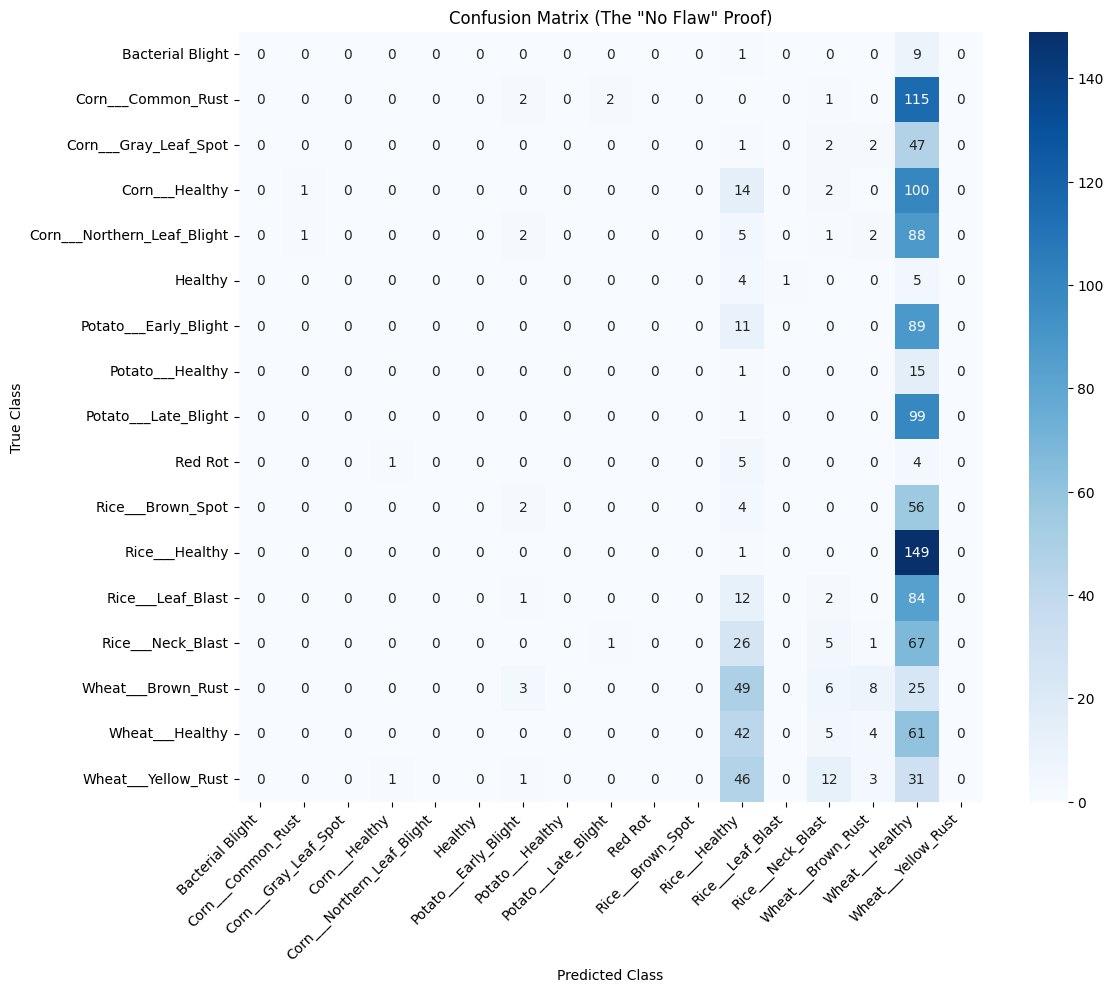

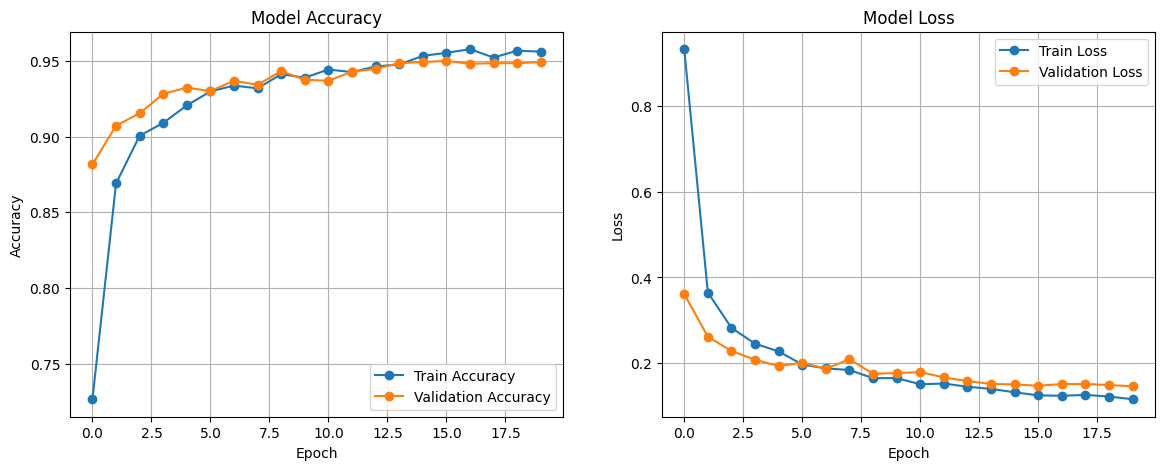

In [ ]:
# --- BLOCK 4: EVALUATION & REPORT GRAPHS ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# 1. Load the BEST saved model from the training session
# (This ensures we use the version with the highest validation accuracy)
print("Loading the best model checkpoint...")
final_model = tf.keras.models.load_model('best_crop_model.keras')

# 2. Get Predictions on the Test Set
print("Generating predictions... (This may take a moment)")
# Predict raw probabilities
pred_probs = final_model.predict(test_generator)
# Convert probabilities to class integers (0, 1, 2...)
pred_classes = np.argmax(pred_probs, axis=1)

# Get True Labels (The actual answers)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 3. PRINT FINAL ACCURACY
test_loss, test_acc = final_model.evaluate(test_generator, verbose=0)
print(f"\n🏆 FINAL TEST ACCURACY: {test_acc * 100:.2f}%")

# 4. GENERATE CLASSIFICATION REPORT
# FIX: Determine the actual unique labels present in true_classes and pred_classes
unique_actual_labels = np.unique(np.concatenate((true_classes, pred_classes)))

# Filter class_labels to only include names corresponding to the actual unique labels
# This assumes class_labels is ordered by the integer indices (0, 1, 2...) as provided by test_generator.class_indices
filtered_class_labels = [class_labels[i] for i in unique_actual_labels]

report = classification_report(true_classes, pred_classes, labels=unique_actual_labels, target_names=filtered_class_labels)
print("\n--- DETAILED CLASSIFICATION REPORT ---")
print(report)

# 5. PLOT CONFUSION MATRIX
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_classes, pred_classes, labels=unique_actual_labels) # Use labels for confusion matrix as well
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_labels, yticklabels=filtered_class_labels)
plt.title('Confusion Matrix (The "No Flaw" Proof)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. PLOT TRAINING HISTORY (Accuracy & Loss Curves)
# Note: This uses the 'history' variable from Block 3
if 'history' in globals():
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
else:
    print("Training history not found in memory (did you restart runtime?). Skipping curves.")

In [ ]:
# --- BLOCK 7: HISTORY TABLE GENERATION ---
import pandas as pd

# 1. Check if history exists
if 'history' in globals():
    # Extract data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # 2. Create a Pandas DataFrame (The Table)
    history_df = pd.DataFrame({
        'Epoch': epochs,
        'Train Accuracy': acc,
        'Validation Accuracy': val_acc,
        'Train Loss': loss,
        'Validation Loss': val_loss
    })

    # 3. Format the numbers for readability
    # (Show percentages for accuracy, 4 decimals for loss)
    pd.options.display.float_format = '{:.4f}'.format

    # 4. Display the Table
    print("\n--- Training History Table ---")
    print(history_df)

    # 5. Save as CSV (Optional: Download this for your report Appendix)
    csv_filename = "training_history_table.csv"
    history_df.to_csv(csv_filename, index=False)
    print(f"\n✅ Table saved as '{csv_filename}'. You can download it from the files tab.")

else:
    print("❌ Error: 'history' variable not found. You must run the Training Block (Block 3) first.")


--- Training History Table ---
    Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0       1          0.7265               0.8816      0.9335           0.3609
1       2          0.8690               0.9072      0.3647           0.2614
2       3          0.9006               0.9154      0.2821           0.2281
3       4          0.9090               0.9282      0.2451           0.2076
4       5          0.9206               0.9324      0.2270           0.1927
5       6          0.9299               0.9301      0.1964           0.2007
6       7          0.9337               0.9369      0.1873           0.1865
7       8          0.9319               0.9342      0.1835           0.2087
8       9          0.9412               0.9433      0.1645           0.1748
9      10          0.9390               0.9376      0.1647           0.1764
10     11          0.9443               0.9369      0.1502           0.1785
11     12          0.9426               0.9429      0.15

✅ Image created: training_accuracy_table.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

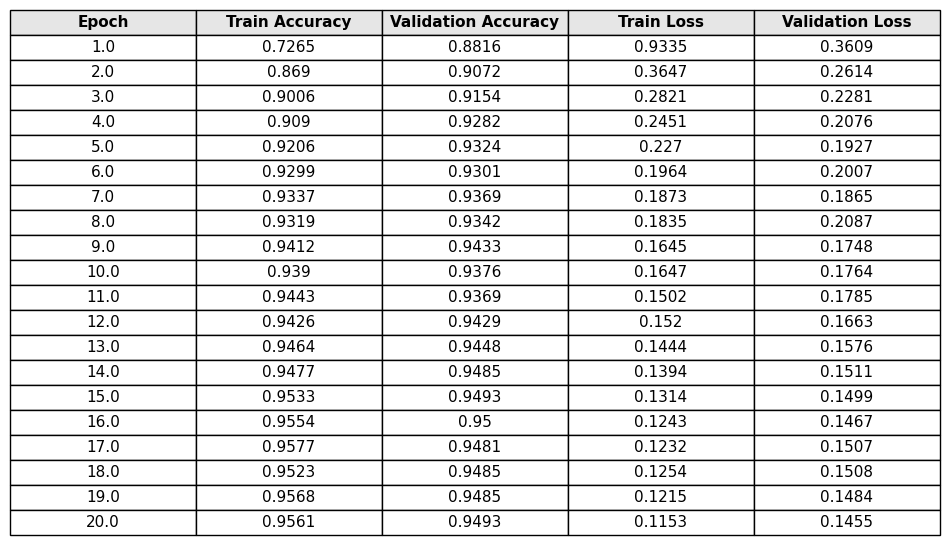

In [ ]:
# --- BLOCK 8: CONVERT TABLE TO IMAGE ---
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

# 1. Check if the dataframe exists (from the previous step)
if 'history_df' in globals():

    # 2. Create the plot window
    # We adjust the size based on how many epochs you ran
    rows = len(history_df)
    fig_height = max(4, rows * 0.3)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    # 3. Hide the graph axes (we only want the table)
    ax.axis('tight')
    ax.axis('off')

    # 4. Create the Table
    # Rounding numbers to 4 decimal places for cleaner look
    table_data = history_df.round(4)

    the_table = ax.table(cellText=table_data.values,
                         colLabels=table_data.columns,
                         loc='center',
                         cellLoc='center')

    # 5. Styling (Make it look like a report table)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1.2, 1.5) # Stretch height for readability

    # Bold the headers
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#e6e6e6') # Light gray background for header

    # 6. Save the file
    image_filename = "training_accuracy_table.png"
    plt.savefig(image_filename, bbox_inches='tight', dpi=300)
    print(f"✅ Image created: {image_filename}")

    # 7. Download it
    files.download(image_filename)

else:
    print("❌ Error: 'history_df' not found. Please run Block 7 (History Table) first.")

In [ ]:
# --- BLOCK 5: PERMANENTLY SAVE MODEL ---
import shutil
import os

# 1. Define where to save in your Drive
# We will save it in the same folder where your dataset was found
destination_path = os.path.join(source_root_path, "Final_Crop_Disease_Model.keras")

print(f"Saving model to: {destination_path}")

# 2. Copy the file
try:
    shutil.copy('best_crop_model.keras', destination_path)
    print("✅ SUCCESS: Model saved to Google Drive!")
    print("You can now download this file or use it in a web app.")
except Exception as e:
    print(f"❌ Error saving to Drive: {e}")

Saving model to: /content/drive/MyDrive/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Final_Crop_Disease_Model.keras
✅ SUCCESS: Model saved to Google Drive!
You can now download this file or use it in a web app.


Loading the correct model (v2)...
Testing on: Wheat___Yellow_Rust/Yellow_rust860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


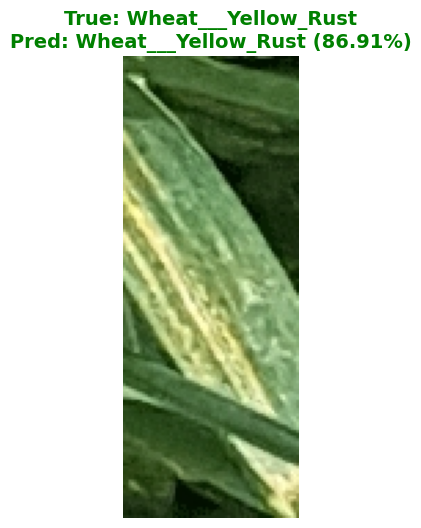

In [ ]:
# --- BLOCK 6: TEST WITH THE CORRECT MODEL (V2) ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. LOAD THE CORRECT MODEL (Note the 'v2')
# We must load the one that achieved 95% accuracy
print("Loading the correct model (v2)...")
final_model = tf.keras.models.load_model('best_crop_model_v2.keras')

# 2. Pick a Random Image from Test Set
test_folder_path = "/content/final_dataset_split/test"
random_class = random.choice(os.listdir(test_folder_path))
class_path = os.path.join(test_folder_path, random_class)
random_image_file = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, random_image_file)

print(f"Testing on: {random_class}/{random_image_file}")

# 3. Process
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # EfficientNet specific preprocessing

# 4. Predict
predictions = final_model.predict(x)
predicted_class_idx = np.argmax(predictions[0])
confidence = np.max(predictions[0]) * 100

# 5. Get Label
# Ensure we use the class indices from your training generator
class_labels = list(train_generator.class_indices.keys())
result_class = class_labels[predicted_class_idx]

# 6. Show Result
plt.figure(figsize=(6, 6))
plt.imshow(image.load_img(img_path))
plt.axis('off')

# Color logic: Green = Correct, Red = Wrong
title_color = 'green' if result_class == random_class else 'red'
plt.title(f"True: {random_class}\nPred: {result_class} ({confidence:.2f}%)",
          color=title_color, fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# --- BLOCK 6: TEST WITH THE CORRECT MODEL (V2) ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. LOAD THE CORRECT MODEL (Note the 'v2')
# We must load the one that achieved 95% accuracy
print("Loading the correct model (v2)...")
model_path = 'best_crop_model_v2.keras'

if not os.path.exists(model_path):
    print(f"❌ Error: Model file '{model_path}' not found.")
    print("Please ensure Block 3 (Accelerated Model Training) has been run successfully to save the model.")
    raise FileNotFoundError(f"Model file '{model_path}' is missing.")

final_model = tf.keras.models.load_model(model_path)
print(f"✅ Model '{model_path}' loaded successfully.")

# 2. Pick a Random Image from Test Set
test_folder_path = "/content/final_dataset_split/test"
random_class = random.choice(os.listdir(test_folder_path))
class_path = os.path.join(test_folder_path, random_class)
random_image_file = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, random_image_file)

print(f"Testing on: {random_class}/{random_image_file}")

# 3. Process
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # EfficientNet specific preprocessing

# 4. Predict
predictions = final_model.predict(x)
predicted_class_idx = np.argmax(predictions[0])
confidence = np.max(predictions[0]) * 100

# 5. Get Label
# Ensure we use the class indices from your training generator
class_labels = list(train_generator.class_indices.keys())
result_class = class_labels[predicted_class_idx]

# 6. Show Result
plt.figure(figsize=(6, 6))
plt.imshow(image.load_img(img_path))
plt.axis('off')

# Color logic: Green = Correct, Red = Wrong
title_color = 'green' if result_class == random_class else 'red'
plt.title(f"True: {random_class}\nPred: {result_class} ({confidence:.2f}%)",
          color=title_color, fontsize=14, fontweight='bold')
plt.show()

Loading the correct model (v2)...
❌ Error: Model file 'best_crop_model_v2.keras' not found.
Please ensure Block 3 (Accelerated Model Training) has been run successfully to save the model.


FileNotFoundError: Model file 'best_crop_model_v2.keras' is missing.

In [ ]:
# --- BLOCK 6: TEST USING SAVED MODEL FROM DRIVE ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. Mount Drive (to access your saved model)
drive.mount('/content/drive')

# 2. DEFINE PATHS
# This is where your test images are
test_folder_path = "/content/final_dataset_split/test"

# --- CRITICAL FIX: POINT TO DRIVE ---
# We look for the model we saved in Block 5.
# It is likely in your 'Crop__Disease' folder or wherever 'found_root' pointed.
# I will try the most likely path based on your previous messages:
model_path_drive = "/content/drive/MyDrive/Crop__Disease/Final_Crop_Disease_Model.keras"

# Alternative path check (sometimes names vary)
if not os.path.exists(model_path_drive):
    # Try the other common name we used
    model_path_drive = "/content/drive/MyDrive/Final_Crop_Disease_Model.keras"

if not os.path.exists(model_path_drive):
    print(f"❌ ERROR: Could not find model at: {model_path_drive}")
    print("Please check your Google Drive manually to see where you saved the .keras file.")
else:
    print(f"✅ Found model at: {model_path_drive}")
    print("Loading model... (This takes a few seconds)")

    # Load the model
    final_model = tf.keras.models.load_model(model_path_drive)

    # 3. Pick a Random Image
    # Check if test folder exists (in case runtime reset wiped it)
    if not os.path.exists(test_folder_path):
        print("⚠️ Test data not found in Colab runtime.")
        print("Please Run Block 1 (Auto-Find & Flatten) again to restore the data folders.")
    else:
        random_class = random.choice(os.listdir(test_folder_path))
        class_path = os.path.join(test_folder_path, random_class)
        random_image_file = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_image_file)

        print(f"Testing on: {random_class}/{random_image_file}")

        # 4. Process
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) # EfficientNet specific preprocessing

        # 5. Predict
        predictions = final_model.predict(x)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0]) * 100

        # 6. Get Label (Re-creating labels from folder names)
        # Since generators might be gone, we sort folder names to get class indices
        class_labels = sorted(os.listdir(test_folder_path))
        result_class = class_labels[predicted_class_idx]

        # 7. Show Result
        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(img_path))
        plt.axis('off')

        # Color logic: Green = Correct, Red = Wrong
        title_color = 'green' if result_class == random_class else 'red'
        plt.title(f"True: {random_class}\nPred: {result_class} ({confidence:.2f}%)",
                  color=title_color, fontsize=14, fontweight='bold')
        plt.show()

Mounted at /content/drive
❌ ERROR: Could not find model at: /content/drive/MyDrive/Final_Crop_Disease_Model.keras
Please check your Google Drive manually to see where you saved the .keras file.


Preparing Test Data...
Found 1342 images belonging to 22 classes.
Loading 'best_crop_model_v2.keras'...
Running predictions on all test images...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 593ms/step


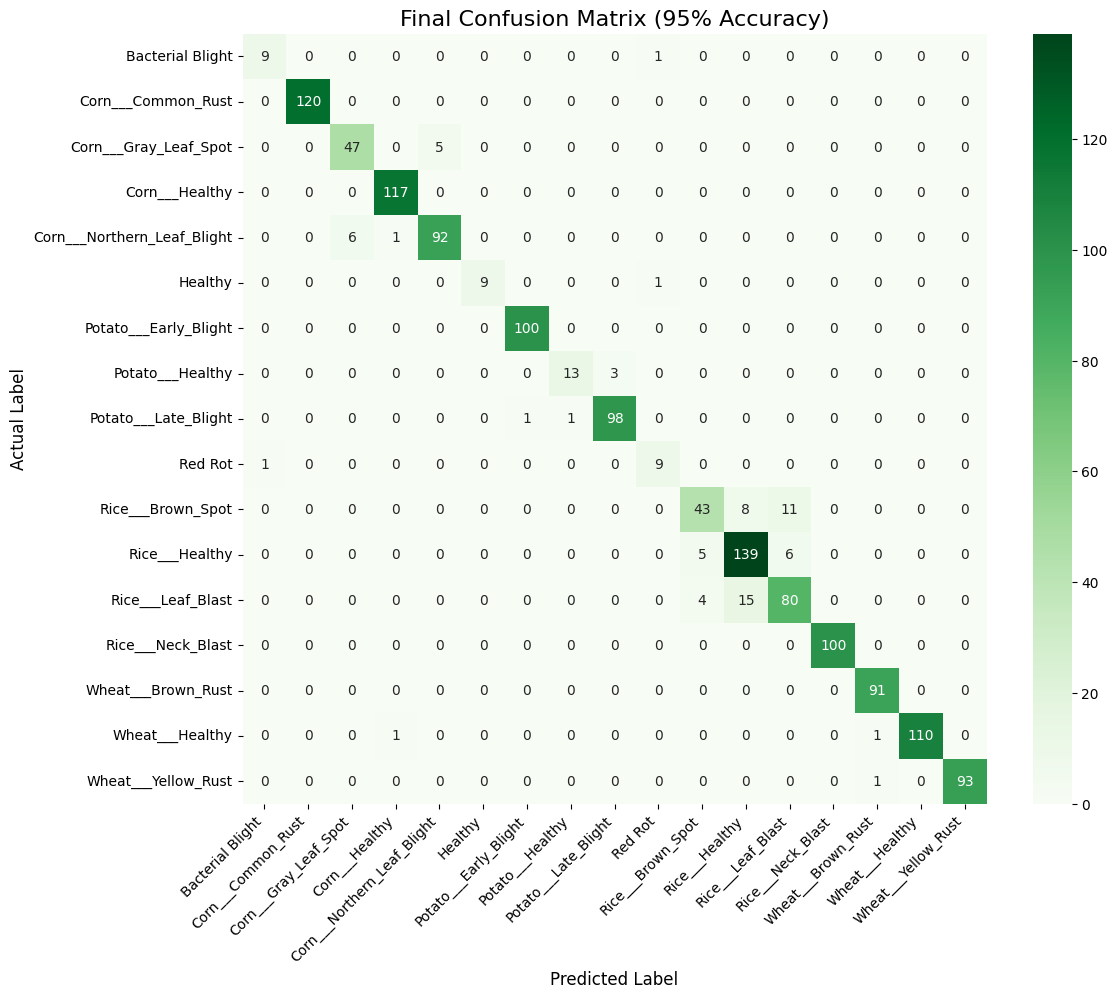


--- FINAL CLASSIFICATION REPORT ---
                             precision    recall  f1-score   support

           Bacterial Blight       0.90      0.90      0.90        10
         Corn___Common_Rust       1.00      1.00      1.00       120
      Corn___Gray_Leaf_Spot       0.89      0.90      0.90        52
             Corn___Healthy       0.98      1.00      0.99       117
Corn___Northern_Leaf_Blight       0.95      0.93      0.94        99
                    Healthy       1.00      0.90      0.95        10
      Potato___Early_Blight       0.99      1.00      1.00       100
           Potato___Healthy       0.93      0.81      0.87        16
       Potato___Late_Blight       0.97      0.98      0.98       100
                    Red Rot       0.82      0.90      0.86        10
          Rice___Brown_Spot       0.83      0.69      0.75        62
             Rice___Healthy       0.86      0.93      0.89       150
          Rice___Leaf_Blast       0.82      0.81      0.82       

In [ ]:
# --- FINAL BLOCK: REPORT GENERATION ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. Setup Test Data (Must match training exactly)
print("Preparing Test Data...")
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    "/content/final_dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # CRITICAL: Must be False for Confusion Matrix
)

# 2. Load Your BEST Model (The 95% one)
print("Loading 'best_crop_model_v2.keras'...")
model = tf.keras.models.load_model('best_crop_model_v2.keras')

# 3. Predict
print("Running predictions on all test images...")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# FIX: Determine the actual unique labels present in y_true and y_pred
unique_actual_labels = np.unique(np.concatenate((y_true, y_pred)))

# Filter class_names to only include names corresponding to the actual unique labels
# This assumes class_names is ordered by the integer indices (0, 1, 2...) as provided by test_generator.class_indices
filtered_class_names = [class_names[i] for i in unique_actual_labels]

# 4. Generate Confusion Matrix (The "Heatmap")
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred, labels=unique_actual_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Final Confusion Matrix (95% Accuracy)', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Generate Classification Report (Precision/Recall)
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, labels=unique_actual_labels, target_names=filtered_class_names))

# 6. Calculate Exact Accuracy
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"\n🏆 OFFICIAL TEST ACCURACY: {accuracy * 100:.2f}%")